# **Racing Data Analysis Project**

## **Project Goal**
The project's goal is to determine which car(s) were dominant overall in the last three seasons (2021, 2022, and 2023), as well as which cars were dominant in each season individually. Additionally, it aims to identify which cars dominated on specific tracks during the 2023 season.

## **1\. Methodology**

###  **1.1. Accrual of points**

Let's award first 10 racers in every race using that system:

1. 1st place: 10 points + 3 bonuses = 13 points
2. 2nd place: 9 points + 2 bonuses = 11 points
3. 3rd place: 8 points + 1 bonus = 9 points
4. 4th place: 7 points
5. 5th place: 6 points
6. 6th place: 5 points
7. 7th place: 4 points
8. 8th place: 3 points
9. 9th place: 2 points
10. 10th place: 1 point



### **1.2. Weighing and normalizing points**

In the gt-world-challenge-europe championships, different tracks may have a different number of races with different durations. There may be 5 races on one track, and 25 on another.

To cope with the varying number of races and their duration, it is important to normalize the scores so that the results are comparable. This can be done in several ways:


### **1.2.1. Weighing by the race duration**

Let's develop a system where points will be multiplied by a coefficient directly proportional to the duration of the race.

Determine the base length of the race = 50 laps.<br>
If the race is longer, for example 64 laps, the points are multiplied by a factor (64/50).<br>
If the race is shorter, for example 42 laps, the points are multiplied by a factor (42/50).<br>
So, if a win is worth 13 points in a 50-lap race, in a 64-lap race it will be worth 13 * (64/50) = 16.64 points.


####  **1.2.2. Normalizing by the number of races**

Divide the total points at each track by the number of races at that track.
For example: If the Mercedes-AMG GT3 scored 60 points in Barcelona in total 3 races, we will divide 60 by 3.


### **1.3. Data visualization**

Present the results graphically for clarity:<br>
Bar Graphs: Displays total points scored or weighted average for each car.

## **2\. Load Libraries**

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scikit_posthocs as sp

## **3\. Load Data**

In [47]:
df = pd.read_parquet(".\\cleaned_data\\race_data.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7319 entries, 0 to 7318
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   Season                7319 non-null   int64          
 1   Meeting               7319 non-null   object         
 2   Event name            7319 non-null   object         
 3   Pos                   7319 non-null   int64          
 4   Car #                 7319 non-null   int64          
 5   Class                 7319 non-null   category       
 6   Special Class         7319 non-null   bool           
 7   Drivers               7319 non-null   object         
 8   Team                  7319 non-null   object         
 9   Car                   7319 non-null   object         
 10  Best lap set          7319 non-null   bool           
 11  Time                  7319 non-null   object         
 12  Time timedelta        7319 non-null   timedelta64[ns]
 13  Lap

## **4\. Add weighted 'Points' column**

In [48]:
# Definition of the point system
points_system = {1: 13, 2: 11, 3: 9, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}

# Function to assign points based on position
def assign_points(pos, laps, weighted, directly_proportional, base_laps=50):
    base_points = points_system.get(pos, 0)
    if weighted == False:
        return base_points
    else:
        if directly_proportional == True:
            # Will give points directly proportional to the duration of the race.
            lap_factor = base_laps / laps
        else:
            # Will give points inversely proportional to the duration of the race.
            lap_factor = laps / base_laps
        return base_points * lap_factor

# Adding a 'Points' column to the DataFrame
df['Points'] = df.apply(lambda row: assign_points(row['Pos'], row['Laps'], weighted = True, directly_proportional = False), axis=1)

#df['Points_without_lap_factor'] = df.apply(lambda row: assign_points(row['Pos'], row['Laps'], weighted = False), axis=1)
#df.to_csv('C:\\Users\\ireev\\Desktop\\data.csv')

### **4.1. Normalizing the 'Points' column**

In [49]:
def normalizing_points(df, column_name, sum_points=True):
    normalized_points = pd.DataFrame()

    # Retrieving unique meetings and seasons
    unique_meetings = df['Meeting'].unique()
    unique_seasons = df['Season'].unique()

    # Looping through all seasons and meetings to handle points
    for season in unique_seasons:
        for meeting in unique_meetings:
            # Filtering data for a specific meeting and season
            filtered_data = df[(df['Meeting'] == meeting) & (df['Season'] == season)]

            if not filtered_data.empty:
                if sum_points:
                    # Summing points by car, sort, and reset index
                    points_by_car = filtered_data.groupby('Car')[column_name].sum().reset_index()
                else:
                    # Just use the filtered data without summing or normalizing
                    points_by_car = filtered_data[['Car', column_name]].copy()

                points_by_car.sort_values(by=column_name, ascending=False, inplace=True)
                points_by_car['Meeting'] = meeting
                points_by_car['Season'] = season
                points_by_car['Pos'] = points_by_car[column_name].rank(method='min', ascending=False).astype(int)

                # Ensuring all necessary columns are present
                columns_to_keep = ['Car', column_name, 'Meeting', 'Season', 'Pos']
                points_by_car = points_by_car[columns_to_keep]

                # Appending to the main dataframe
                normalized_points = pd.concat([normalized_points, points_by_car], ignore_index=True)

    return normalized_points


# Displaying the final dataframe
normalized_points_sum = normalizing_points(df, 'Points', True)
normalized_points = normalizing_points(df, 'Points', False)

normalized_points_sum.head()

#normalized_points.to_csv('C:\\Users\\ireev\\Desktop\\normalized_points_False.csv')

,Car,Points,Meeting,Season,Pos
0,Mercedes-AMG GT3,92.42,Barcelona,2021,1
1,Porsche 911 GT3-R (991.II),60.98,Barcelona,2021,2
2,Lamborghini Huracan GT3 EVO,49.20,Barcelona,2021,3
3,Audi R8 LMS GT3,33.06,Barcelona,2021,4
4,Ferrari 488 GT3,30.04,Barcelona,2021,5


In [50]:
normalized_points.head()

,Car,Points,Meeting,Season,Pos
0,Mercedes-AMG GT3,24.70,Barcelona,2021,1
1,Porsche 911 GT3-R (991.II),20.90,Barcelona,2021,2
2,Mercedes-AMG GT3,20.54,Barcelona,2021,3
3,Porsche 911 GT3-R (991.II),17.38,Barcelona,2021,4
4,Audi R8 LMS GT3,17.10,Barcelona,2021,5


In [51]:
normalized_points[(normalized_points['Meeting'] == 'Barcelona') & 
                        (normalized_points['Season'] == 2021) & 
                        (normalized_points['Car'] == 'Porsche 911 GT3-R (991.II)')]['Points'].sum()

60.980000000000004

---------------------


Define overall lider/s by points it's not really suitable. Because some race tracks has more racing events than others, such as on Spa. And this may skew our data.

## Best By points

### Overall lider/s

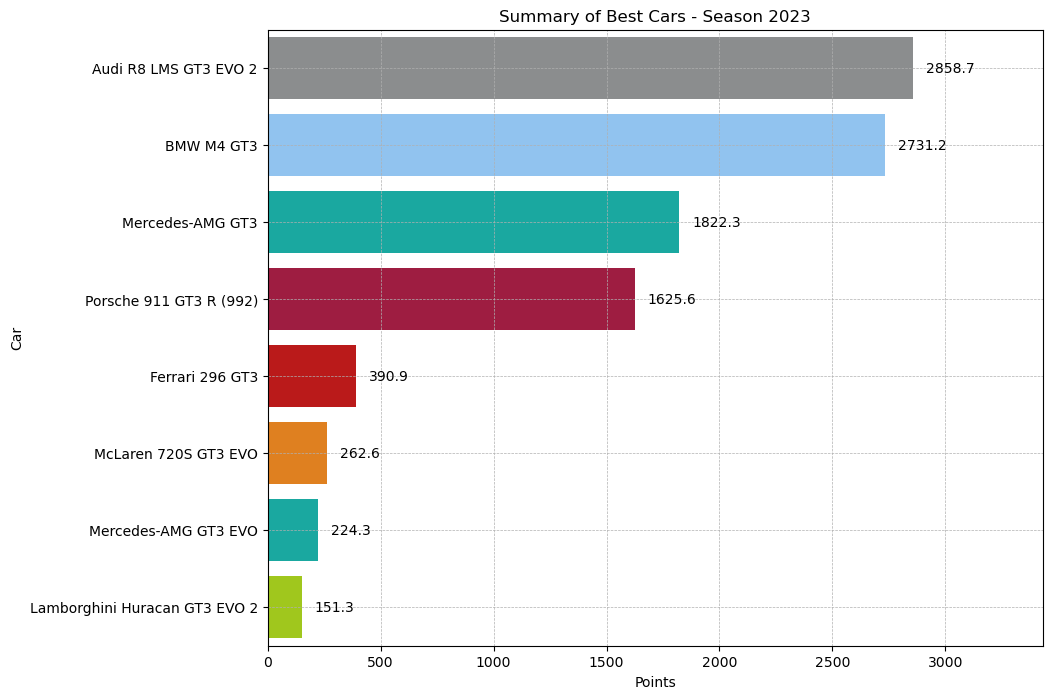

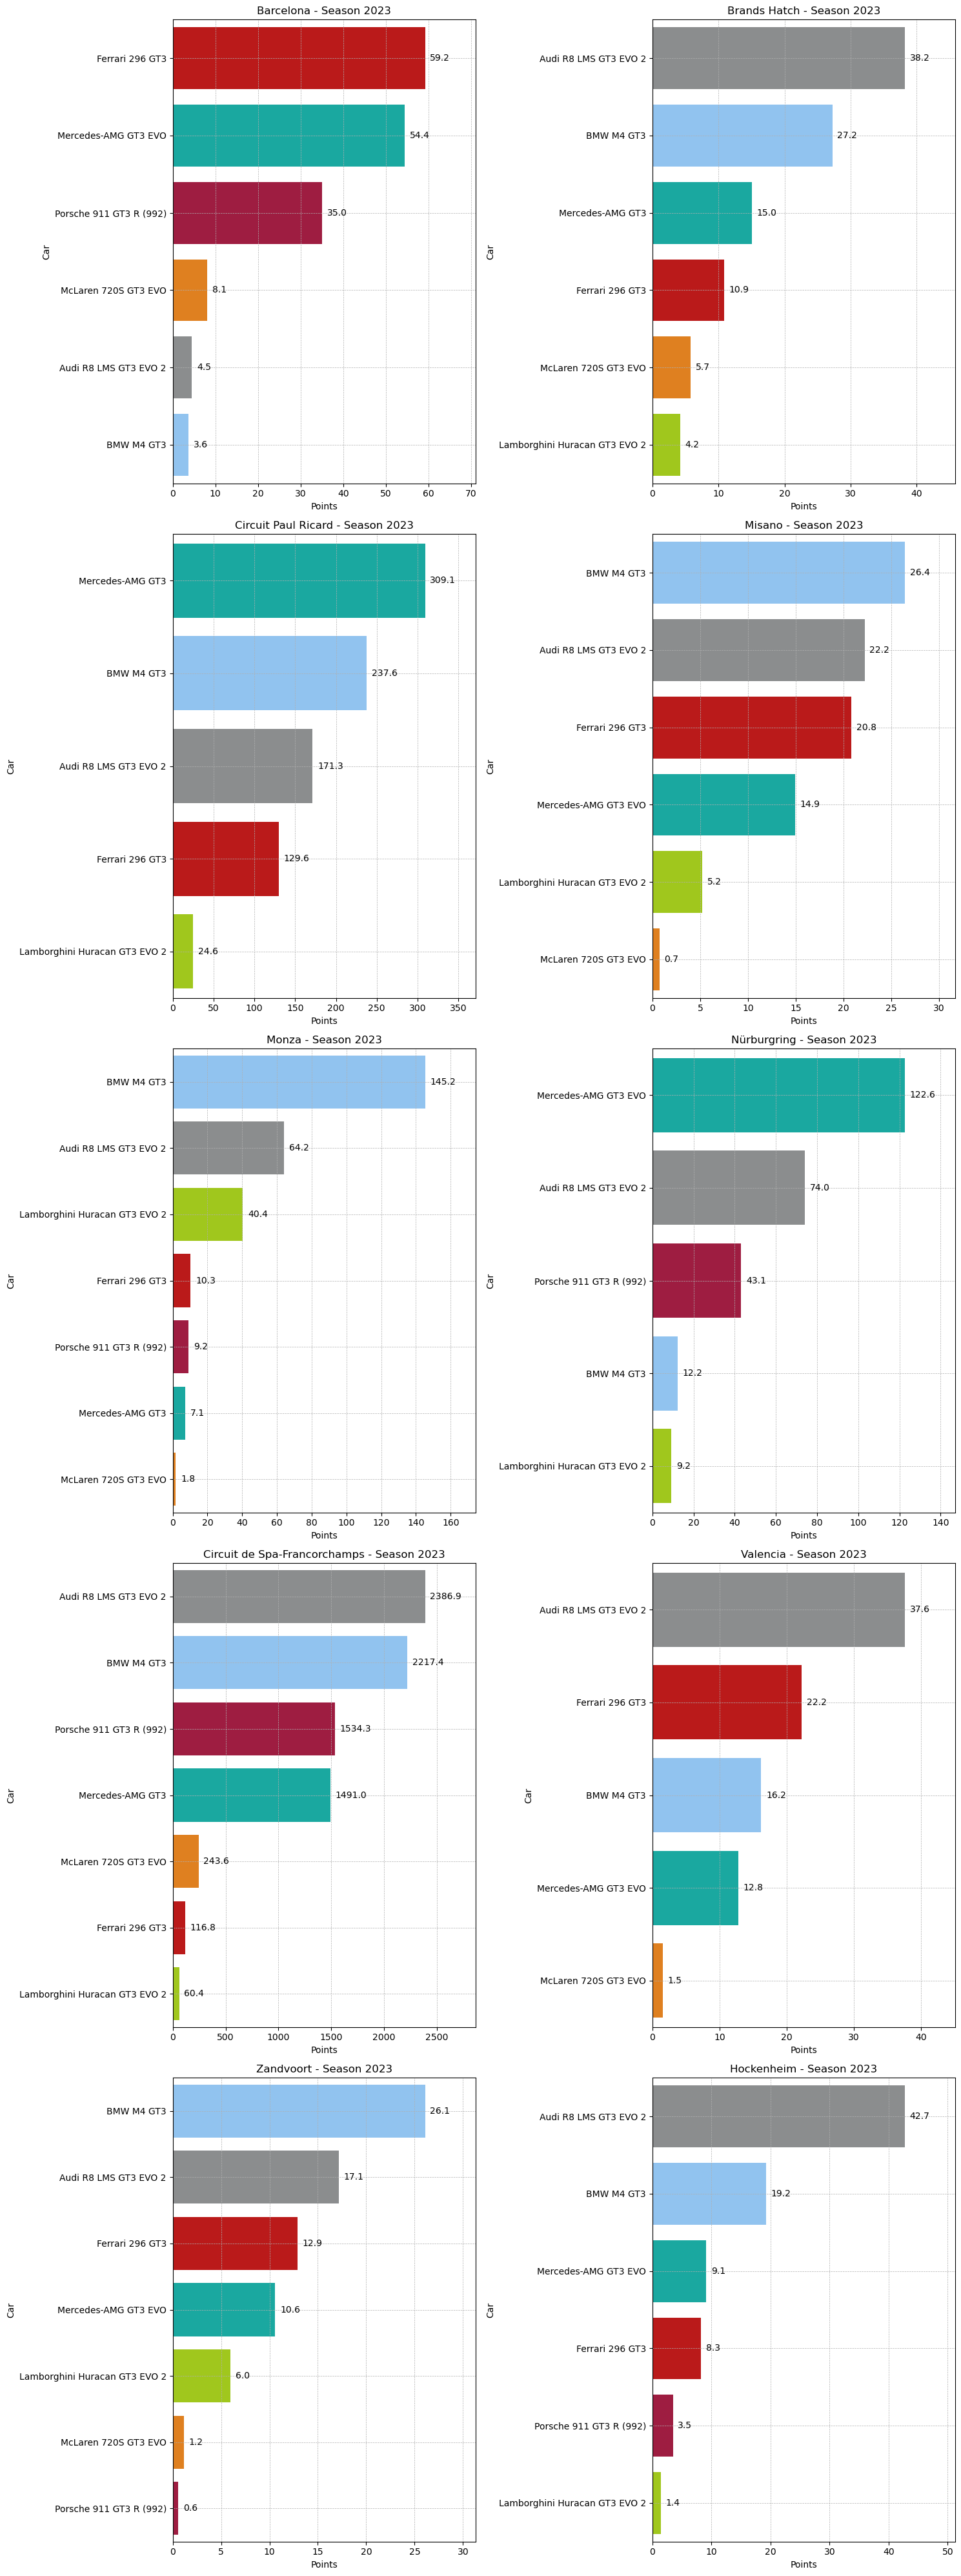

In [78]:
colors ={
    'Aston Martin Vantage AMR GT3' : '#004225',
    'Aston Martin Vantage GT3': '#004225',
    'Bentley Continental GT3': '#0d8f52',
    'Audi R8 LMS GT3': '#8a8d8f', 
    'Audi R8 LMS GT3 EVO 2': '#8a8d8f',
    'BMW M4 GT3': '#81c4ff',
    'BMW M6 GT3': '#81c4ff',
    'Ferrari 296 GT3': '#d40000', 
    'Ferrari 488 GT3': '#d40000', 
    'Honda NSX GT3': '#292828',
    'Honda NSX GT3 EVO 2': '#292828', 
    'Lamborghini Huracan GT3 EVO': '#afe301', 
    'Lamborghini Huracan GT3 EVO 2': '#afe301',
    'McLaren 720S GT3': '#ff8000',
    'McLaren 720S GT3 EVO': '#ff8000',
    'Mercedes-AMG GT3': '#03bfb5',
    'Mercedes-AMG GT3 EVO': '#03bfb5',
    'Mercedes-AMG GT3 2020': '#03bfb5', 
    'Porsche 911 GT3 R (992)': '#B30838', 
    'Porsche 911 GT3-R (991.II)': '#B30838'
}


def plot_summary(data, title_suffix):
    summary_data = data.groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='Points', y='Car', data=summary_data, hue='Car', palette=colors, ax=ax, legend=False)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f'Summary of Best Cars - {title_suffix}')
    adjust_text_positions(ax, summary_data['Points'])
    plt.show()


def plot_individual_track(data, ax, title):
    sns.barplot(x='Points', y='Car', data=data, hue='Car', palette=colors, ax=ax, legend=False)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title)
    adjust_text_positions(ax, data['Points'])


def adjust_text_positions(ax, points):
    max_points = points.max()
    ax.set_xlim(0, max_points * 1.20)  # Increase maximum 20% for text
    
    for i, point in enumerate(points):
        x_position = point + max_points * 0.02  # small indentation on the right
        if x_position > ax.get_xlim()[1]:
            x_position = point - max_points * 0.02
            ha = 'right'
        else:
            ha = 'left'
        ax.text(x_position, i, f'{point:.1f}', color='black', va='center', ha=ha)



def plot_tracks(df, season, summary=False):

    if season == "All":
        data = df[df['Points'] > 0]
        title_suffix = "All Seasons"
    else:
        data = df[(df['Season'] == season) & (df['Points'] > 0)]
        title_suffix = f"Season {season}"

    if summary:
        # Summary graph for all tracks in the selected season
        plot_summary(data, title_suffix)
    else:
        # Graphs for each track in the season
        unique_meetings = data['Meeting'].unique()
        num_meetings = len(unique_meetings)
        fig, axes = plt.subplots(nrows=(num_meetings + 1) // 2, ncols=2, figsize=(15, 8 * num_meetings // 2))
        axes = axes.flatten()
        
        for i, meeting in enumerate(unique_meetings):
            meeting_data = data[data['Meeting'] == meeting]
            plot_individual_track(meeting_data, axes[i], title=f'{meeting} - {title_suffix}')
        
        # Remove empty subgraphs if they exist
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()



# Примеры вызова функции
plot_tracks(normalized_points_sum, 2023, summary=True)  # Суммарный график за все сезоны
plot_tracks(normalized_points_sum, 2023, summary=False)  # Графики для каждой трассы сезона 2021

#plot_tracks(filtered_data_summed, "All", summary=True)  # Суммарный график за все сезоны
